In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import stats 
import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs
from matplotlib.lines import Line2D
from scipy.stats import linregress


### Functions

In [19]:
# Load the statistics CSV file
combined_statistics_path = r"C:\Users\Feifei\Box\BR_remote_sensing\ebi_combined_statistics.csv"
df = pd.read_csv(combined_statistics_path)


# other File paths
root_dir = r'C:\Users\Feifei\Box\BR_remote_sensing\ebi_results'
discharge_dir = r'C:\Users\Feifei\Box\BR_remote_sensing\water_discharge_data\processed'
galeazzi_file_path = r"C:\Users\Feifei\Box\BR_remote_sensing\Galeazzi_eBI.csv"

# Load the Galeazzi file to get discharge file names
galeazzi_df = pd.read_csv(galeazzi_file_path)

In [24]:

def fit_regression(x, y, mode="log-x"):
    """
    Fit a regression model with optional transformations.
    
    Modes:
      "linear"  : y = m*x + b
      "log-y"   : y = exp(m*x + b)  [fitting log10(y) vs. x]
      "log-x"   : y = m*log10(x) + b
      "log-log" : y = exp(m*log10(x) + b)  [fitting log10(y) vs. log10(x)]
    """
    if mode == "linear":
        slope, intercept = np.polyfit(x, y, 1)
        predict = lambda x_new: slope * x_new + intercept
    elif mode == "log-y":
        y_trans = np.log10(y)
        slope, intercept = np.polyfit(x, y_trans, 1)
        predict = lambda x_new: 10**(slope * x_new + intercept)
    elif mode == "log-x":
        x_trans = np.log10(x)
        slope, intercept = np.polyfit(x_trans, y, 1)
        predict = lambda x_new: slope * np.log10(x_new) + intercept
    elif mode == "log-log":
        x_trans = np.log10(x)
        y_trans = np.log10(y)
        slope, intercept = np.polyfit(x_trans, y_trans, 1)
        predict = lambda x_new: 10**(slope * np.log10(x_new) + intercept)
    else:
        raise ValueError("Unsupported mode. Choose 'linear', 'log-y', 'log-x', or 'log-log'.")
    return slope, intercept, predict


def plot_regression(x, y, predict, ax=None, label="Regression"):
    """
    Plot original data points and the regression line.

    Parameters:
        x (array-like): Original independent variable data.
        y (array-like): Original dependent variable data.
        predict (function): Function that takes x-values and returns predicted y-values (on original scale).
        ax (matplotlib.axes.Axes, optional): An axes object to plot on. Creates one if None.
        label (str): Label for the regression line.

    Returns:
        ax (matplotlib.axes.Axes): The axes object with the plot.
    """
    if ax is None:
        fig, ax = plt.subplots()
    
    # Plot data points.
    ax.scatter(x, y, color='blue', label="Data Points")
    
    # Create a set of x-values for plotting the regression line.
    x_line = np.linspace(np.min(x), np.max(x), 100)
    y_line = predict(x_line)
    ax.plot(x_line, y_line, color='red', label=label)
    
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.legend()
    return ax



def classify_river(sinuosity, mean_bi):
    if mean_bi >= 3.5:
        return 'B'  # Multichannels
    elif mean_bi >= 1.4:
        if sinuosity >= 1.4:
            return 'HSW'  # High-sinuosity wandering
        else:
            return 'LSW'  # Low-sinuosity wandering
    else:
        return 'M'  # Single channel
    

# Helper function to load discharge data based on the Galeazzi file
def load_discharge_data(river_name):
    discharge_file_name = galeazzi_df.loc[galeazzi_df['River_Station'] == river_name, 'ID_discharge'].values
    if len(discharge_file_name) > 0:
        discharge_file = f"{discharge_file_name[0]}.csv"
        discharge_path = os.path.join(discharge_dir, discharge_file)
        if os.path.exists(discharge_path):
            discharge_df = pd.read_csv(discharge_path)
            discharge_df['date'] = pd.to_datetime(discharge_df['date'], format='%m/%d/%Y')
            discharge_df['Year'] = discharge_df['date'].dt.year
            yearly_avg_discharge = discharge_df.groupby('Year')['Q'].mean().reset_index()
            return yearly_avg_discharge
        else:
            print(f"Discharge file not found for {river_name}: {discharge_file}")
            return pd.DataFrame()
    else:
        print(f"ID_discharge not found for {river_name} in Galeazzi file.")
        return pd.DataFrame()


In [16]:

def classify_river(sinuosity, mean_bi):
    if mean_bi >= 3.5:
        return 'B'  # Multichannels
    elif mean_bi >= 1.4:
        if sinuosity >= 1.4:
            return 'HSW'  # High-sinuosity wandering
        else:
            return 'LSW'  # Low-sinuosity wandering
    else:
        return 'M'  # Single channel


def plot_regression(ax, x, y, color, label, marker, linewidth=5.0):
    # Convert x and y to numpy arrays to avoid index issues
    x = x.values
    y = y.values

    # Sorting the x-values and corresponding y-values
    sorted_indices = np.argsort(x)
    x_sorted = x[sorted_indices]
    y_sorted = y[sorted_indices]
    
    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x_sorted, y_sorted)
    
    # Prepare regression line
    reg_line = slope * x_sorted + intercept
    ax.plot(x_sorted, reg_line, color=color, label=f'{label} (slope: {slope:.2f})', linewidth=linewidth)
    
    # Confidence interval (95% CI)
    ci = 1.96 * std_err * np.sqrt(1/len(x_sorted) + (x_sorted - np.mean(x_sorted))**2 / np.sum((x_sorted - np.mean(x_sorted))**2))
    ax.fill_between(x_sorted, reg_line - ci, reg_line + ci, color=color, alpha=0.2)
    print(f"{label} Slope: {slope:.2f}, Confidence Interval (95%): {ci[0]:.2f} - {ci[-1]:.2f}, R-squared: {r_value**2:.2f}")

def fit_regression(x_data, y_data, x_range):
    log_x_data = np.log(x_data)
    slope, intercept, r_value, p_value, std_err = stats.linregress(log_x_data, y_data)
    r_squared = r_value**2  # Calculate R^2 value
    
    line_x = np.linspace(np.log(x_range[0]), np.log(x_range[1]), 300)
    line_y = slope * line_x + intercept
    print(f"Slope: {slope:.4f}, Intercept: {intercept:.4f}, R-squared: {r_squared:.4f}")  # Print slope, intercept, and R^2
    
    return np.exp(line_x), line_y, slope, intercept



### Figure 4


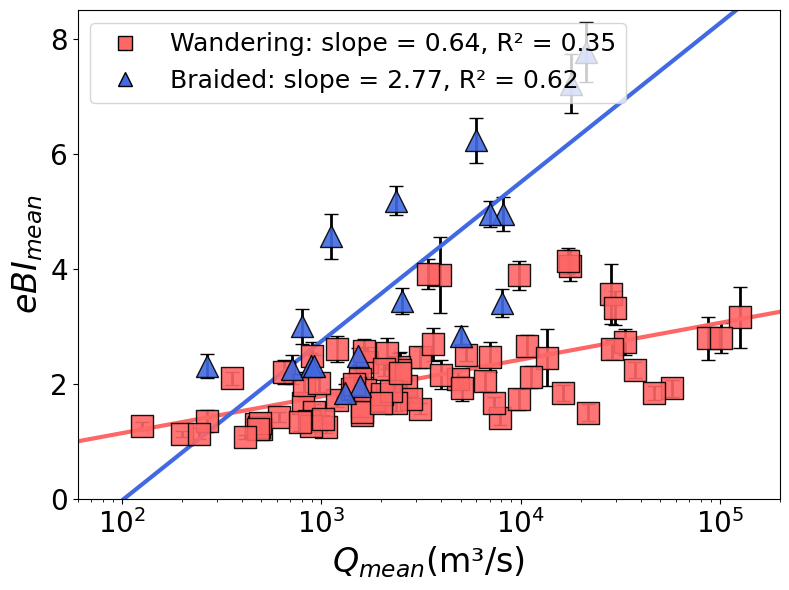

In [25]:
# Initialize x-axis range (full range for the plot)
x_range = (60, 2e5)

# Group classifications: combine wandering types
wandering_types = ['HSW', 'LSW']
df['Group'] = df['Classification'].replace(wandering_types, 'Wandering')

# Define markers and colors for the groups
markers = {'Wandering': 's', 'B': '^'}
colors = {'Wandering': '#FF6666', 'B': '#4169E1'}

# Create the figure and axes
fig, ax = plt.subplots(figsize=(8, 6))

# Dictionary to store slope and R² information for the legend
legend_info = {}

# Loop through each group to compute and plot the regression line.
for group in ['Wandering', 'B']:
    subset = df[df['Group'] == group]
    x_data = subset['Qm']
    y_data = subset['Mean_eBI_annual']
    
    # Ensure x_data are positive (needed for log transformation)
    if any(x_data <= 0):
        raise ValueError(f"Group {group} contains non-positive x values, cannot use log transformation.")
    
    # Fit the regression model using mode "log-x"
    slope, intercept, predict = fit_regression(x_data, y_data, mode="log-x")
    
    # Compute R² on the original data:
    y_pred_data = predict(x_data)
    ss_res = np.sum((y_data - y_pred_data) ** 2)
    ss_tot = np.sum((y_data - np.mean(y_data)) ** 2)
    r2 = 1 - ss_res / ss_tot
    
    # Generate regression line values over the full x_range.
    x_line = np.linspace(x_range[0], x_range[1], 100)
    y_line = predict(x_line)
    
    # Plot the regression line.
    ax.plot(x_line, y_line, color=colors[group], lw=3)
    
    # Store slope and R² for the legend.
    legend_info[group] = f"slope = {slope:.2f}, R² = {r2:.2f}"

# Plot data points with error bars for each group.
for group in ['Wandering', 'B']:
    subset = df[df['Group'] == group]
    x_data = subset['Qm']
    y_data = subset['Mean_eBI_annual']
    error_data = subset['ebi_error_annual']
    
    # Plot error bars.
    ax.errorbar(x_data, y_data, yerr=error_data, fmt='none',
                ecolor='black', elinewidth=2, capsize=5, zorder=1)
    # Plot scatter points.
    ax.scatter(x_data, y_data, label=group, marker=markers[group],
               c=colors[group], edgecolors='black', s=250, alpha=0.9, zorder=2)

# Set x-axis to log scale and adjust limits.
ax.set_xscale('log')
ax.set_xlim(*x_range)
ax.set_ylim(0, 8.5)

# Set labels and tick parameters.
ax.set_xlabel(r'${Q_{mean}}$(m³/s)', fontsize=24)
ax.set_ylabel(r'${eBI_{mean}}$', fontsize=24)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)

# Create custom legend elements showing the slope and R².
legend_elements = [
    Line2D([0], [0], marker=markers['Wandering'], color='w',
           label=f"Wandering: {legend_info['Wandering']}",
           markerfacecolor=colors['Wandering'], markersize=10, markeredgecolor='black'),
    Line2D([0], [0], marker=markers['B'], color='w',
           label=f"Braided: {legend_info['B']}",
           markerfacecolor=colors['B'], markersize=10, markeredgecolor='black')
]
ax.legend(handles=legend_elements, fontsize=18, loc='upper left')

plt.tight_layout()
plt.show()

fig.savefig(r"C:\Users\Feifei\Box\BR_remote_sensing\figures\mean_eBI_Q.pdf", 
            format='pdf', dpi=500, bbox_inches='tight', transparent=True)


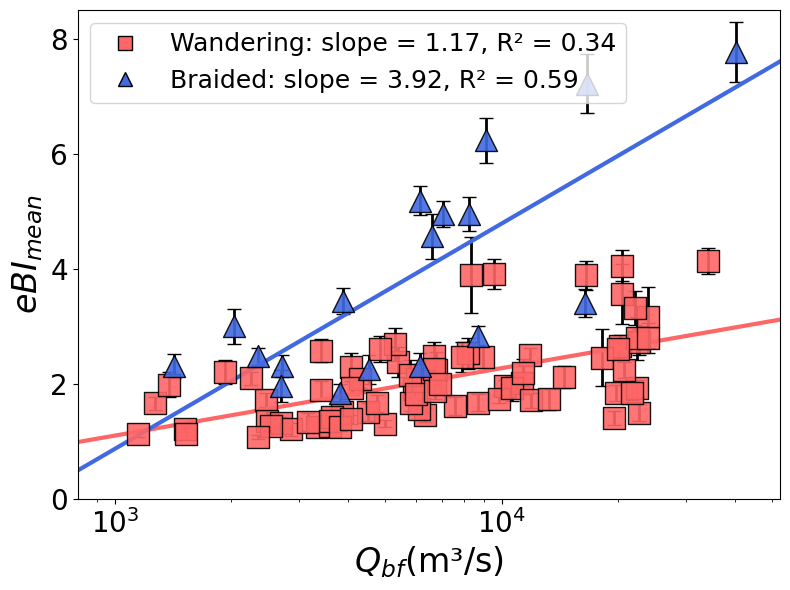

In [27]:
# Dynamically calculate x_range based on data (with some padding)
x_range = (df['Qbf point'].min() * 0.7, df['Qbf point'].max() * 1.3)

# Combine wandering classifications into one group
wandering_types = ['HSW', 'LSW']
df['Group'] = df['Classification'].replace(wandering_types, 'Wandering')

# Define markers and colors for groups
markers = {'Wandering': 's', 'B': '^'}
colors = {'Wandering': '#FF6666', 'B': '#4169E1'}

# Create the figure and axes
fig, ax = plt.subplots(figsize=(8, 6))

# Dictionary to store slope and R² information for the legend
legend_info = {}

# Loop through each group to compute and plot the regression line.
for group in ['Wandering', 'B']:
    subset = df[df['Group'] == group]
    x_data = subset['Qbf point']
    y_data = subset['Mean_eBI_annual']
    
    # Use mode "log-x": regression of y = m*log(x) + b
    slope, intercept, predict = fit_regression(x_data, y_data, mode="log-x")
    
    # Compute predictions on the original x_data and then R²
    y_pred_data = predict(x_data)
    ss_res = np.sum((y_data - y_pred_data) ** 2)
    ss_tot = np.sum((y_data - np.mean(y_data)) ** 2)
    r2 = 1 - ss_res / ss_tot
    
    # Generate a set of x-values over the original x_range
    x_line = np.linspace(x_range[0], x_range[1], 300)
    y_line = predict(x_line)
    
    # Plot the regression line
    ax.plot(x_line, y_line, color=colors[group], lw=3)
    
    # Store slope and R² information for the legend.
    legend_info[group] = f"slope = {slope:.2f}, R² = {r2:.2f}"

# Plot data points with error bars
for group in ['Wandering', 'B']:
    subset = df[df['Group'] == group]
    x_data = subset['Qbf point']
    y_data = subset['Mean_eBI_annual']
    error_data = subset['ebi_error_annual']
    
    # Plot error bars first...
    ax.errorbar(x_data, y_data, yerr=error_data, fmt='none',
                ecolor='black', elinewidth=2, capsize=5, zorder=1)
    # ...then scatter the data points.
    ax.scatter(x_data, y_data, label=group, marker=markers[group],
               c=colors[group], edgecolors='black', s=250, alpha=0.9, zorder=2)

# Set x-axis to log scale and adjust limits
ax.set_xscale('log')
ax.set_xlim(*x_range)
ax.set_ylim(0, 8.5)

# Set labels and tick parameters
ax.set_xlabel(r'${Q_{bf}}$(m³/s)', fontsize=24)
ax.set_ylabel(r'${eBI_{mean}}$', fontsize=24)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)

# Create a legend with slope and R² values.
legend_elements = [
    Line2D([0], [0], marker=markers['Wandering'], color='w',
           label=f"Wandering: {legend_info['Wandering']}",
           markerfacecolor=colors['Wandering'], markersize=10, markeredgecolor='black'),
    Line2D([0], [0], marker=markers['B'], color='w',
           label=f"Braided: {legend_info['B']}",
           markerfacecolor=colors['B'], markersize=10, markeredgecolor='black')
]
ax.legend(handles=legend_elements, fontsize=18, loc='upper left')

plt.tight_layout()
plt.show()

fig.savefig(r"C:\Users\Feifei\Box\BR_remote_sensing\figures\bankful_eBI_Q.pdf", 
            format='pdf', dpi=500, bbox_inches='tight', transparent=True)



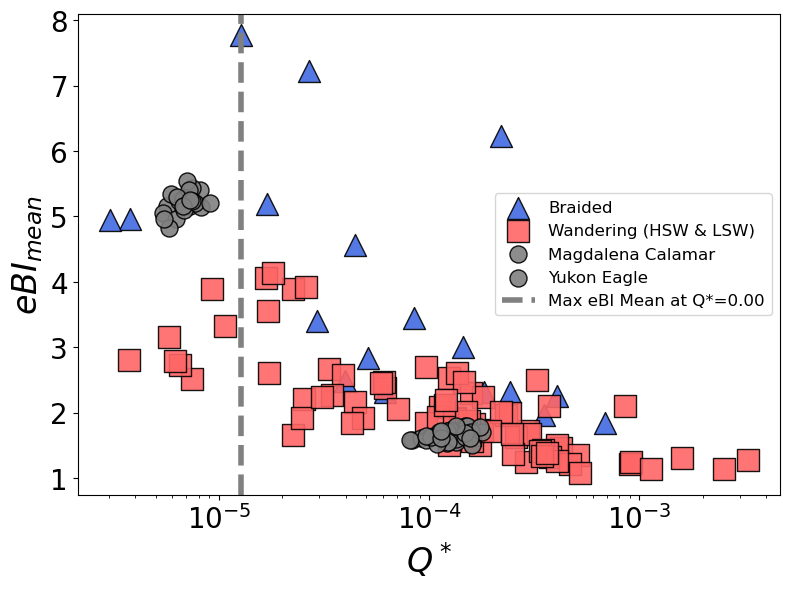

In [22]:
# Load combined statistics to get Qbf point and wetted area
combined_stats_df = pd.read_csv(combined_statistics_path)

# Gravitational acceleration in m/s^2
g = 9.81

# Calculate dim_Q for wandering and braided rivers using Qbf point
combined_stats_df['dim_Q'] = combined_stats_df['Qbf point'] / (g**0.5 * combined_stats_df['wetted_area_avg_subannual']**(5/2))

# Find the data point with the maximum Mean_BI_annual
max_ebi_row = combined_stats_df.loc[combined_stats_df['Mean_BI_annual'].idxmax()]
max_dim_Q = max_ebi_row['dim_Q']
max_ebi = max_ebi_row['Mean_BI_annual']

# Define target rivers
target_rivers = ['Magdalena_Calamar', 'Yukon_Eagle']
discharge_data = {}
ebi_data = {}



# Load discharge and eBI data for each target river
for river in target_rivers:
    discharge_data[river] = load_discharge_data(river)
    ebi_annual_file = os.path.join(root_dir, river, 'rivgraph', 'eBI_results_annual.csv')
    if os.path.exists(ebi_annual_file):
        ebi_df = pd.read_csv(ebi_annual_file)
        ebi_data[river] = ebi_df[['Year', 'eBI']].groupby('Year').mean().reset_index()
    else:
        print(f"eBI results not found for {river}.")

# Merge discharge and eBI data for each target river
target_river_data = {}
for river in target_rivers:
    if river in discharge_data and river in ebi_data:
        merged_df = pd.merge(discharge_data[river], ebi_data[river], on='Year', how='inner')
        if not merged_df.empty:
            wetted_area = combined_stats_df.loc[combined_stats_df['River'] == river, 'wetted_area_avg_subannual'].values[0]
            if wetted_area > 0:
                # Calculate yearly dim_Q for target rivers
                merged_df['dim_Q'] = merged_df['Q'] / (g**0.5 * wetted_area**(5/2))
                target_river_data[river] = merged_df
            else:
                print(f"No valid wetted_area value for {river}.")
        else:
            print(f"No common years for merging data in {river}.")
    else:
        print(f"Discharge or eBI data missing for {river}.")

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))

# Define markers and colors for wandering and braided rivers
markers = {'Wandering': 's', 'B': '^'}  # Combined HSW and LSW symbols
colors = {'Wandering': '#FF6666', 'B': '#4169E1'}

# Planform type descriptions
planform_type = {'Wandering': 'Wandering (HSW & LSW)', 'B': 'Braided'}

# Loop through classifications and plot wandering and braided rivers
for cls, description in [('B', 'Braided'), ('Wandering', 'Wandering (HSW & LSW)')]:
    if cls == 'Wandering':
        subset = combined_stats_df[combined_stats_df['Classification'].isin(['HSW', 'LSW'])]  # Combine HSW and LSW
    else:
        subset = combined_stats_df[combined_stats_df['Classification'] == cls]
    
    x_data = subset['dim_Q']
    y_data = subset['Mean_eBI_annual']
    ax.scatter(
        x_data, y_data, label=description, 
        marker=markers[cls], c=colors[cls], edgecolors='black', s=250, alpha=0.9
    )

# Add target rivers to the plot
target_colors = {'Magdalena_Calamar': 'gray', 'Yukon_Eagle': 'gray'}  # Colors for the target rivers
for river, data in target_river_data.items():
    ax.scatter(
        data['dim_Q'], data['eBI'],  # Plot yearly dim_Q vs. yearly mean eBI
        label=river.replace('_', ' '), 
        s=150, alpha=0.9, edgecolors='black', c=target_colors[river], marker='o'
    )

# Draw a vertical line at the dim_Q with max Mean_eBI_annual
ax.axvline(max_dim_Q, color='gray', linestyle='--', linewidth=4, label=f'Max eBI Mean at Q*={max_dim_Q:.2f}')

# Set axis labels and properties
ax.set_xlabel(r'${Q^*}$', fontsize=24)  # X-axis labeled as Q*
ax.set_ylabel(r'${eBI_{mean}}$', fontsize=24)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.set_xscale('log')

# Add legend
ax.legend(fontsize=12, loc='best')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# Save the figure
fig.savefig(r"C:\Users\Feifei\Box\BR_remote_sensing\figures\eBI_dim_Q.pdf", 
            format='pdf', dpi=500, bbox_inches='tight', transparent=True)




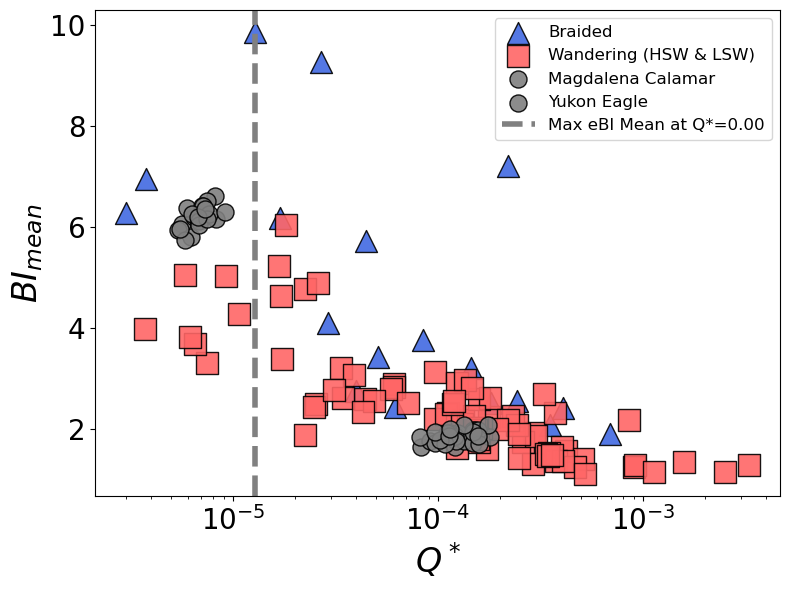

In [ ]:
# Load combined statistics to get Qbf point and wetted area
combined_stats_df = pd.read_csv(combined_statistics_path)

# Gravitational acceleration in m/s^2
g = 9.81

# Calculate dim_Q for wandering and braided rivers using Qbf point
combined_stats_df['dim_Q'] = combined_stats_df['Qbf point'] / (g**0.5 * combined_stats_df['wetted_area_avg_subannual']**(5/2))

# Find the data point with the maximum Mean_BI_annual
max_ebi_row = combined_stats_df.loc[combined_stats_df['Mean_BI_annual'].idxmax()]
max_dim_Q = max_ebi_row['dim_Q']
max_ebi = max_ebi_row['Mean_BI_annual']

# Define target rivers
target_rivers = ['Magdalena_Calamar', 'Yukon_Eagle']
discharge_data = {}
ebi_data = {}


# Load discharge and eBI data for each target river
for river in target_rivers:
    discharge_data[river] = load_discharge_data(river)
    ebi_annual_file = os.path.join(root_dir, river, 'rivgraph', 'BI_results_annual.csv')
    if os.path.exists(ebi_annual_file):
        ebi_df = pd.read_csv(ebi_annual_file)
        ebi_data[river] = ebi_df[['Year', 'BI']].groupby('Year').mean().reset_index()
    else:
        print(f"eBI results not found for {river}.")

# Merge discharge and eBI data for each target river
target_river_data = {}
for river in target_rivers:
    if river in discharge_data and river in ebi_data:
        merged_df = pd.merge(discharge_data[river], ebi_data[river], on='Year', how='inner')
        if not merged_df.empty:
            wetted_area = combined_stats_df.loc[combined_stats_df['River'] == river, 'wetted_area_avg_subannual'].values[0]
            if wetted_area > 0:
                # Calculate yearly dim_Q for target rivers
                merged_df['dim_Q'] = merged_df['Q'] / (g**0.5 * wetted_area**(5/2))
                target_river_data[river] = merged_df
            else:
                print(f"No valid wetted_area value for {river}.")
        else:
            print(f"No common years for merging data in {river}.")
    else:
        print(f"Discharge or eBI data missing for {river}.")

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))

# Define markers and colors for wandering and braided rivers
markers = {'Wandering': 's', 'B': '^'}  # Combined HSW and LSW symbols
colors = {'Wandering': '#FF6666', 'B': '#4169E1'}

# Planform type descriptions
planform_type = {'Wandering': 'Wandering (HSW & LSW)', 'B': 'Braided'}

# Loop through classifications and plot wandering and braided rivers
for cls, description in [('B', 'Braided'), ('Wandering', 'Wandering (HSW & LSW)')]:
    if cls == 'Wandering':
        subset = combined_stats_df[combined_stats_df['Classification'].isin(['HSW', 'LSW'])]  # Combine HSW and LSW
    else:
        subset = combined_stats_df[combined_stats_df['Classification'] == cls]
    
    x_data = subset['dim_Q']
    y_data = subset['Mean_BI_annual']
    ax.scatter(
        x_data, y_data, label=description, 
        marker=markers[cls], c=colors[cls], edgecolors='black', s=250, alpha=0.9
    )

# Add target rivers to the plot
target_colors = {'Magdalena_Calamar': 'gray', 'Yukon_Eagle': 'gray'}  # Colors for the target rivers
for river, data in target_river_data.items():
    ax.scatter(
        data['dim_Q'], data['BI'],  # Plot yearly dim_Q vs. yearly mean eBI
        label=river.replace('_', ' '), 
        s=150, alpha=0.9, edgecolors='black', c=target_colors[river], marker='o'
    )

# Draw a vertical line at the dim_Q with max Mean_BI_annual
ax.axvline(max_dim_Q, color='gray', linestyle='--', linewidth=4, label=f'Max eBI Mean at Q*={max_dim_Q:.2f}')

# Set axis labels and properties
ax.set_xlabel(r'${Q^*}$', fontsize=24)  # X-axis labeled as Q*
ax.set_ylabel(r'${BI_{mean}}$', fontsize=24)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.set_xscale('log')

# Add legend
ax.legend(fontsize=12, loc='best')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# Save the figure
fig.savefig(r"C:\Users\Feifei\Box\BR_remote_sensing\figures\BI_dim_Q.pdf", 
            format='pdf', dpi=500, bbox_inches='tight', transparent=True)

### Q bankful

Slope: 0.0455, Intercept: 0.5033, R-squared: 0.1671
Slope: 0.0195, Intercept: 0.4489, R-squared: 0.0252


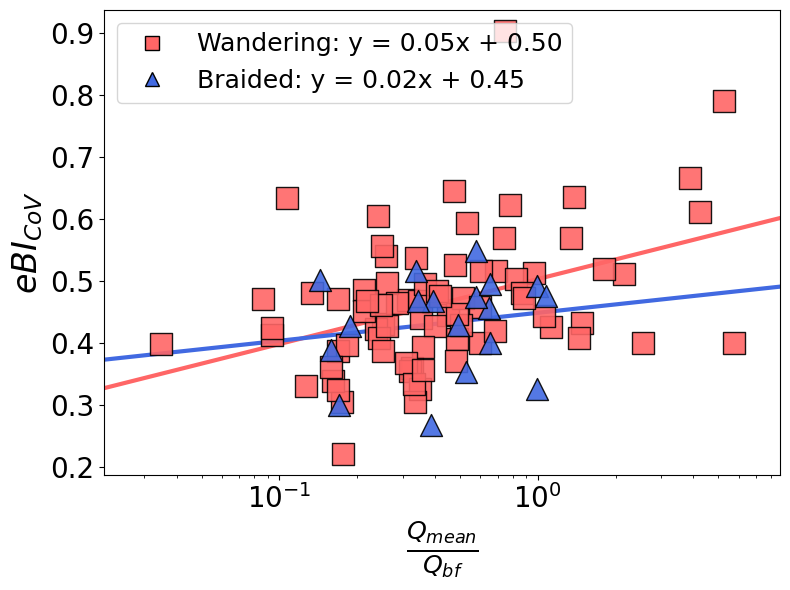

In [14]:
# Calculate intermittency factor
df['intermittency_factor'] = df['Qm'] / df['Qbf point']

# Dynamically calculate x_range based on data
x_range = (df['intermittency_factor'].min() * 0.6, df['intermittency_factor'].max() * 1.5)  # Add 10% padding

def fit_regression(x_data, y_data, x_range=x_range):
    log_x_data = np.log(x_data)
    slope, intercept, r_value, p_value, std_err = stats.linregress(log_x_data, y_data)
    r_squared = r_value**2  # Calculate R^2 value
    
    line_x = np.linspace(np.log(x_range[0]), np.log(x_range[1]), 300)
    line_y = slope * line_x + intercept
    print(f"Slope: {slope:.4f}, Intercept: {intercept:.4f}, R-squared: {r_squared:.4f}")  # Print slope, intercept, and R^2
    
    return np.exp(line_x), line_y, slope, intercept

# Create the figure and axes
fig, ax = plt.subplots(figsize=(8, 6))

# Define markers and colors
markers = {'Wandering': 's', 'B': '^'}  # Combined HSW and LSW symbols
colors = {'Wandering': '#FF6666', 'B': '#4169E1'}

# Combine wandering classifications into one group
df['Group'] = df['Classification'].replace(wandering_types, 'Wandering')

# Variables to store regression line equations for legend
legend_labels = {}
for group in ['Wandering', 'B']:
    subset = df[df['Group'] == group]
    x_data = subset['intermittency_factor']
    y_data = subset['cov_ebi_annual']
    line_x, line_y, slope, intercept = fit_regression(x_data, y_data, x_range)
    
    # Plot regression line
    ax.plot(line_x, line_y, color=colors[group], lw=3)
    
    # Store regression equation for legend
    legend_labels[group] = f"{slope:.2f}x + {intercept:.2f}"

# Plot data points with error bars
for group in ['Wandering', 'B']:
    subset = df[df['Group'] == group]
    x_data = subset['intermittency_factor']
    y_data = subset['cov_ebi_annual']
    error_data = subset['ebi_error_annual']
    
    # Scatter plot with error bars
    #ax.errorbar(x_data, y_data, yerr=error_data, fmt='none', ecolor='black', elinewidth=2, capsize=5, zorder=1)
    ax.scatter(x_data, y_data, label=group, marker=markers[group], c=colors[group], edgecolors='black', 
               s=250, alpha=0.9, zorder=2)

# Set log scale for x-axis
ax.set_xscale('log')
#ax.set_ylim(bottom=0, top=8.5)
ax.set_xlim(*x_range)

# Set labels and ticks
ax.set_xlabel(r'$\frac{Q_{mean}}{Q_{bf}}$', fontsize=26)  # Display fraction as LaTeX
ax.set_ylabel(r'${eBI_{CoV}}$', fontsize=24)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)

# Create a legend with regression equations
legend_elements = [
    Line2D([0], [0], marker=markers['Wandering'], color='w',
           label=f"Wandering: y = {legend_labels['Wandering']}",
           markerfacecolor=colors['Wandering'], markersize=10, markeredgecolor='black'),
    Line2D([0], [0], marker=markers['B'], color='w',
           label=f"Braided: y = {legend_labels['B']}",
           markerfacecolor=colors['B'], markersize=10, markeredgecolor='black')
]

ax.legend(handles=legend_elements, fontsize=18, loc='upper left')

# Tight layout and save figure
plt.tight_layout()
plt.show()

fig.savefig(r"C:\Users\Feifei\Box\BR_remote_sensing\figures\eBI_cov_intermittency.pdf", 
            format='pdf', dpi=500, bbox_inches='tight', transparent=True)




Slope: -0.0564, Intercept: 0.8262, R-squared: 0.4774
Slope: -0.0563, Intercept: 0.8212, R-squared: 0.2294


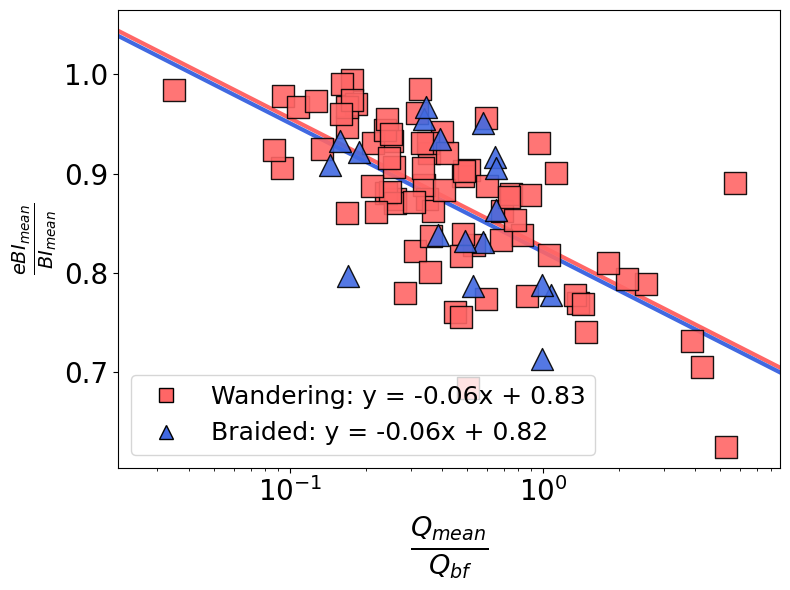

In [15]:
# Calculate intermittency factor
df['intermittency_factor'] = df['Qm'] / df['Qbf point']
#df['eBI_BI_ratio'] = df['Mean_eBI_annual'] / df['Mean_BI_annual']

# Dynamically calculate x_range based on data
x_range = (df['intermittency_factor'].min() * 0.6, df['intermittency_factor'].max() * 1.5)  # Add 10% padding

def fit_regression(x_data, y_data, x_range=x_range):
    log_x_data = np.log(x_data)
    slope, intercept, r_value, p_value, std_err = stats.linregress(log_x_data, y_data)
    r_squared = r_value**2  # Calculate R^2 value
    
    line_x = np.linspace(np.log(x_range[0]), np.log(x_range[1]), 300)
    line_y = slope * line_x + intercept
    print(f"Slope: {slope:.4f}, Intercept: {intercept:.4f}, R-squared: {r_squared:.4f}")  # Print slope, intercept, and R^2
    
    return np.exp(line_x), line_y, slope, intercept

# Create the figure and axes
fig, ax = plt.subplots(figsize=(8, 6))

# Define markers and colors
markers = {'Wandering': 's', 'B': '^'}  # Combined HSW and LSW symbols
colors = {'Wandering': '#FF6666', 'B': '#4169E1'}

# Combine wandering classifications into one group
df['Group'] = df['Classification'].replace(wandering_types, 'Wandering')

# Variables to store regression line equations for legend
legend_labels = {}
for group in ['Wandering', 'B']:
    subset = df[df['Group'] == group]
    x_data = subset['intermittency_factor']
    y_data = subset['eBI_BI_ratio_time']
    line_x, line_y, slope, intercept = fit_regression(x_data, y_data, x_range)
    
    # Plot regression line
    ax.plot(line_x, line_y, color=colors[group], lw=3)
    
    # Store regression equation for legend
    legend_labels[group] = f"{slope:.2f}x + {intercept:.2f}"

# Plot data points with error bars
for group in ['Wandering', 'B']:
    subset = df[df['Group'] == group]
    x_data = subset['intermittency_factor']
    y_data = subset['eBI_BI_ratio_time']
    error_data = subset['ebi_error_annual']
    
    # Scatter plot with error bars
    #ax.errorbar(x_data, y_data, yerr=error_data, fmt='none', ecolor='black', elinewidth=2, capsize=5, zorder=1)
    ax.scatter(x_data, y_data, label=group, marker=markers[group], c=colors[group], edgecolors='black', 
               s=250, alpha=0.9, zorder=2)

# Set log scale for x-axis
ax.set_xscale('log')
#ax.set_ylim(bottom=0, top=8.5)
ax.set_xlim(*x_range)

# Set labels and ticks
ax.set_xlabel(r'$\frac{Q_{mean}}{Q_{bf}}$', fontsize=28)  # Display fraction as LaTeX
ax.set_ylabel(r'$\frac{eBI_{mean}}{BI_{mean}}$', fontsize=20)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)

# Create a legend with regression equations
legend_elements = [
    Line2D([0], [0], marker=markers['Wandering'], color='w',
           label=f"Wandering: y = {legend_labels['Wandering']}",
           markerfacecolor=colors['Wandering'], markersize=10, markeredgecolor='black'),
    Line2D([0], [0], marker=markers['B'], color='w',
           label=f"Braided: y = {legend_labels['B']}",
           markerfacecolor=colors['B'], markersize=10, markeredgecolor='black')
]

ax.legend(handles=legend_elements, fontsize=18, loc='lower left')

# Tight layout and save figure
plt.tight_layout()
plt.show()

fig.savefig(r"C:\Users\Feifei\Box\BR_remote_sensing\figures\eBI_BI_intermittency.pdf", 
            format='pdf', dpi=500, bbox_inches='tight', transparent=True)


Slope: -0.0475, Intercept: 0.8601, R-squared: 0.4364
Slope: -0.0553, Intercept: 0.8328, R-squared: 0.2129


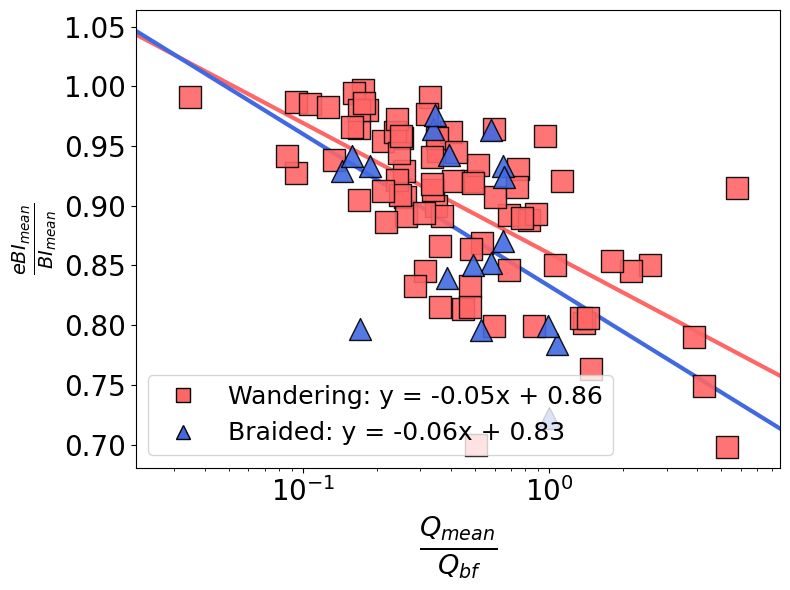

In [ ]:


# Dynamically calculate x_range based on data
x_range = (df['Iw'].min() * 0.6, df['Iw'].max() * 1.5)  # Add 10% padding


# Create the figure and axes
fig, ax = plt.subplots(figsize=(8, 6))

# Define markers and colors
markers = {'Wandering': 's', 'B': '^'}  # Combined HSW and LSW symbols
colors = {'Wandering': '#FF6666', 'B': '#4169E1'}

# Combine wandering classifications into one group
df['Group'] = df['Classification'].replace(wandering_types, 'Wandering')

# Variables to store regression line equations for legend
legend_labels = {}
for group in ['Wandering', 'B']:
    subset = df[df['Group'] == group]
    x_data = subset['Iw']
    y_data = subset['eBI_BI_ratio_time']
    line_x, line_y, slope, intercept = fit_regression(x_data, y_data, x_range)
    
    # Plot regression line
    ax.plot(line_x, line_y, color=colors[group], lw=3)
    
    # Store regression equation for legend
    legend_labels[group] = f"{slope:.2f}x + {intercept:.2f}"

# Plot data points with error bars
for group in ['Wandering', 'B']:
    subset = df[df['Group'] == group]
    x_data = subset['Iw']
    y_data = subset['eBI_BI_ratio_time']
    error_data = subset['ebi_error_annual']
    
    # Scatter plot with error bars
    #ax.errorbar(x_data, y_data, yerr=error_data, fmt='none', ecolor='black', elinewidth=2, capsize=5, zorder=1)
    ax.scatter(x_data, y_data, label=group, marker=markers[group], c=colors[group], edgecolors='black', 
               s=250, alpha=0.9, zorder=2)

# Set log scale for x-axis
ax.set_xscale('log')
#ax.set_ylim(bottom=0, top=8.5)
ax.set_xlim(*x_range)

# Set labels and ticks
ax.set_xlabel(r'$\frac{Q_{mean}}{Q_{bf}}$', fontsize=28)  # Display fraction as LaTeX
ax.set_ylabel(r'$\frac{eBI_{mean}}{BI_{mean}}$', fontsize=28)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)

# Create a legend with regression equations
legend_elements = [
    Line2D([0], [0], marker=markers['Wandering'], color='w',
           label=f"Wandering: y = {legend_labels['Wandering']}",
           markerfacecolor=colors['Wandering'], markersize=10, markeredgecolor='black'),
    Line2D([0], [0], marker=markers['B'], color='w',
           label=f"Braided: y = {legend_labels['B']}",
           markerfacecolor=colors['B'], markersize=10, markeredgecolor='black')
]

ax.legend(handles=legend_elements, fontsize=18, loc='lower left')

# Tight layout and save figure
plt.tight_layout()
plt.show()

fig.savefig(r"C:\Users\Feifei\Box\BR_remote_sensing\figures\5_eBI_BI_Iw_time.pdf", 
            format='pdf', dpi=500, bbox_inches='tight', transparent=True)

KeyError: 'intermittency_factor'

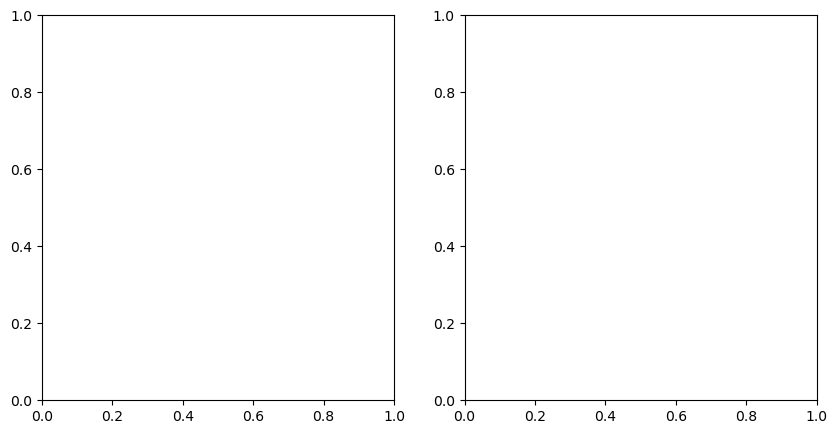

In [23]:
# Climate zone mapping with high-contrast colors
climate_full_names = {
    'A': 'Tropical',
    'B': 'Arid',
    'C': 'Temperate',
    'D': 'Cold',
    'E': 'Polar'
}

climate_colors = {
    'A': '#1f77b4',  # Tropical (blue)
    'B': '#ff7f0e',  # Arid (orange)
    'C': '#2ca02c',  # Temperate (green)
    'D': '#d62728',  # Cold (red)
    'E': '#9467bd'   # Polar (purple)
}

# Planform type mapping
markers = {'HSW': 's', 'LSW': 's', 'B': '^'}  # Combined HSW and LSW symbols
planform_type_labels = {'HSW': 'Wandering', 'LSW': 'Wandering', 'B': 'Braided'}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Function to get color based on climate group
def get_color(climate_class):
    if isinstance(climate_class, str) and climate_class:  # Ensure it's a valid string
        return climate_colors.get(climate_class[0], '#7f7f7f')  # Default to gray if unknown
    return '#7f7f7f'  # Default color for missing or invalid values

# Plot Intermittency Factor vs. Mean eBI Annual
for cls in ['HSW', 'LSW', 'B']:
    subset = df[df['Classification'] == cls]
    for _, row in subset.iterrows():
        climate_zone = row['Climate Zone']
        ax1.scatter(
            row['intermittency_factor'], row['Mean_eBI_annual'],
            marker=markers[cls], c=get_color(climate_zone),
            edgecolors='black', s=150, alpha=0.9
        )

# Plot Intermittency Factor vs. CoV eBI Annual
for cls in ['HSW', 'LSW', 'B']:
    subset = df[df['Classification'] == cls]
    for _, row in subset.iterrows():
        climate_zone = row['Climate Zone']
        ax2.scatter(
            row['intermittency_factor'], row['cov_ebi_annual'],
            marker=markers[cls], c=get_color(climate_zone),
            edgecolors='black', s=150, alpha=0.9
        )

# Create legends
# Climate legend
climate_legend = [
    Line2D([0], [0], marker='o', color='w', label=climate_full_names[group],
           markerfacecolor=color, markersize=10, markeredgecolor='black')
    for group, color in climate_colors.items()
]

# Planform type legend
planform_legend = [
    Line2D([0], [0], marker=markers['B'], color='w', label='Braided',
           markerfacecolor='gray', markersize=10, markeredgecolor='black'),
    Line2D([0], [0], marker=markers['HSW'], color='w', label='Wandering',
           markerfacecolor='gray', markersize=10, markeredgecolor='black')
]

# Add legends
fig.legend(handles=climate_legend + planform_legend, loc='upper center', bbox_to_anchor=(0.5, 1.15),
           ncol=3, fontsize=12, frameon=False)

# Set labels and format
for ax in (ax1, ax2):
    ax.set_xlabel(r'$\frac{Q_{mean}}{Q_{bf}}$', fontsize=18)  # Display fraction as LaTeX
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    ax.set_xscale('log')

ax1.set_ylabel(r'${eBI_{mean}}$', fontsize=18)
ax2.set_ylabel(r'${eBI_{CoV}}$', fontsize=18)

# Adjust layout and display
plt.tight_layout()
plt.show()


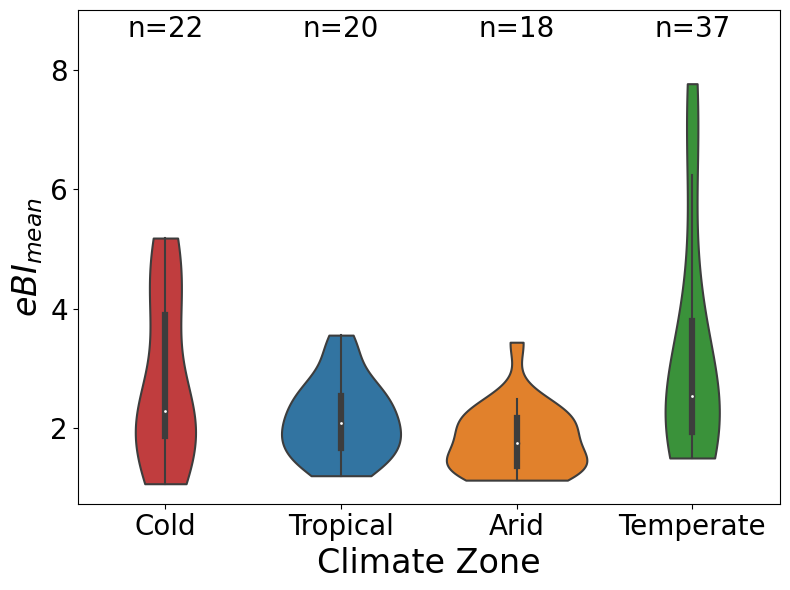

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Climate zone mapping
climate_full_names = {
    'A': 'Tropical',
    'B': 'Arid',
    'C': 'Temperate',
    'D': 'Cold',
    'E': 'Polar'
}

# Full name color mapping
climate_colors_full = {
    'Tropical': '#1f77b4',  # Tropical (blue)
    'Arid': '#ff7f0e',      # Arid (orange)
    'Temperate': '#2ca02c', # Temperate (green)
    'Cold': '#d62728',      # Cold (red)
    'Polar': '#9467bd'      # Polar (purple)
}

# Extract the first letter from Climate Zone and map to full names
df['Climate Group'] = df['Climate Zone'].apply(lambda x: x[0] if isinstance(x, str) else None)
df['Climate Group Full Name'] = df['Climate Group'].map(climate_full_names)

# Calculate sample size for each Climate Group
sample_sizes = df.groupby('Climate Group Full Name').size()

# Create a figure for the violin plot
fig, ax = plt.subplots(figsize=(8, 6))

# Violin plot for all rivers
sns.violinplot(
    x='Climate Group Full Name', y='Mean_eBI_annual',
    data=df, palette=climate_colors_full, ax=ax, cut=0  # Set cut=0 to prevent extending beyond data range
)
ax.set_ylim(top=9)

# Add sample sizes as a single line above the violins
for i, climate in enumerate(sample_sizes.index):
    ax.text(i, ax.get_ylim()[1] * 0.95, f'n={sample_sizes[climate]}', 
            ha='center', fontsize=20, color='black')

# Set plot titles and labels
ax.set_xlabel('Climate Zone', fontsize=24)
ax.set_ylabel(r'${eBI_{mean}}$', fontsize=24)
ax.tick_params(axis='x', labelsize=20)  # Rotate for clarity
ax.tick_params(axis='y', labelsize=20)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

fig.savefig(r"C:\Users\Feifei\Box\BR_remote_sensing\figures\eBI_mean_boxplot.pdf", 
            format='pdf', dpi=500, bbox_inches='tight', transparent=True)



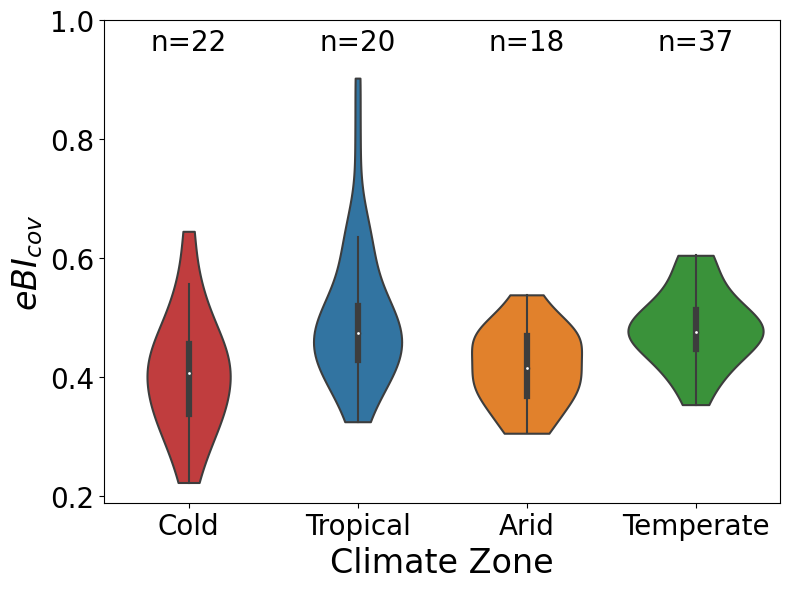

In [19]:
# Climate zone mapping
climate_full_names = {
    'A': 'Tropical',
    'B': 'Arid',
    'C': 'Temperate',
    'D': 'Cold',
    'E': 'Polar'
}

# Full name color mapping
climate_colors_full = {
    'Tropical': '#1f77b4',  # Tropical (blue)
    'Arid': '#ff7f0e',      # Arid (orange)
    'Temperate': '#2ca02c', # Temperate (green)
    'Cold': '#d62728',      # Cold (red)
    'Polar': '#9467bd'      # Polar (purple)
}

# Extract the first letter from Climate Zone and map to full names
df['Climate Group'] = df['Climate Zone'].apply(lambda x: x[0] if isinstance(x, str) else None)
df['Climate Group Full Name'] = df['Climate Group'].map(climate_full_names)

# Calculate sample size for each Climate Group
sample_sizes = df.groupby('Climate Group Full Name').size()

# Create a figure for the violin plot
fig, ax = plt.subplots(figsize=(8, 6))

# Violin plot for all rivers
sns.violinplot(
    x='Climate Group Full Name', y='cov_ebi_annual',
    data=df, palette=climate_colors_full, ax=ax, cut=0  # Set cut=0 to prevent extending beyond data range
)
ax.set_ylim(top=1)

# Add sample sizes as a single line above the violins
for i, climate in enumerate(sample_sizes.index):
    ax.text(i, ax.get_ylim()[1] * 0.95, f'n={sample_sizes[climate]}', 
            ha='center', fontsize=20, color='black')

# Set plot titles and labels
ax.set_xlabel('Climate Zone', fontsize=24)
ax.set_ylabel(r'${eBI_{cov}}$', fontsize=24)
ax.tick_params(axis='x', labelsize=20)  # Rotate for clarity
ax.tick_params(axis='y', labelsize=20)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

fig.savefig(r"C:\Users\Feifei\Box\BR_remote_sensing\figures\eBI_cov_boxplot.pdf", 
            format='pdf', dpi=500, bbox_inches='tight', transparent=True)



### Figure 5

Slope: -0.0547, Intercept: 1.3515, R-squared: 0.4273
Slope: -0.0055, Intercept: 0.9231, R-squared: 0.0040


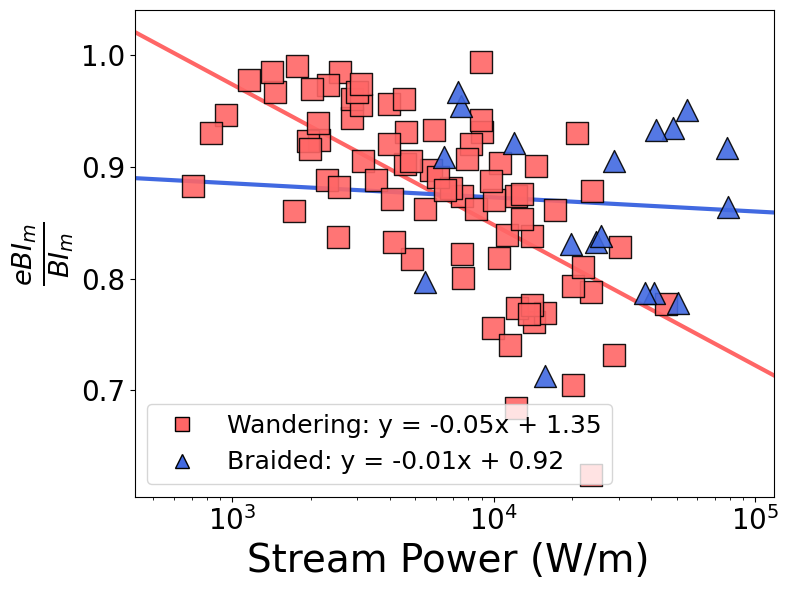

In [ ]:

# Dynamically calculate x_range based on data
x_range = (df['Stream Power (W/m) '].min() * 0.6, df['Stream Power (W/m) '].max() * 1.5)  # Add 10% padding




# Create the figure and axes
fig, ax = plt.subplots(figsize=(8, 6))

# Define markers and colors
markers = {'Wandering': 's', 'B': '^'}  # Combined HSW and LSW symbols
colors = {'Wandering': '#FF6666', 'B': '#4169E1'}

# Combine wandering classifications into one group
df['Group'] = df['Classification'].replace(wandering_types, 'Wandering')

# Variables to store regression line equations for legend
legend_labels = {}
for group in ['Wandering', 'B']:
    subset = df[df['Group'] == group]
    x_data = subset['Stream Power (W/m) ']
    y_data = subset['eBI_BI_ratio_time']
    line_x, line_y, slope, intercept = fit_regression(x_data, y_data, x_range)
    
    # Plot regression line
    ax.plot(line_x, line_y, color=colors[group], lw=3)
    
    # Store regression equation for legend
    legend_labels[group] = f"{slope:.2f}x + {intercept:.2f}"

# Plot data points with error bars
for group in ['Wandering', 'B']:
    subset = df[df['Group'] == group]
    x_data = subset['Stream Power (W/m) ']
    y_data = subset['eBI_BI_ratio_time']
    error_data = subset['ebi_error_annual']
    
    # Scatter plot with error bars
    #ax.errorbar(x_data, y_data, yerr=error_data, fmt='none', ecolor='black', elinewidth=2, capsize=5, zorder=1)
    ax.scatter(x_data, y_data, label=group, marker=markers[group], c=colors[group], edgecolors='black', 
               s=250, alpha=0.9, zorder=2)

# Set log scale for x-axis
ax.set_xscale('log')
#ax.set_ylim(bottom=0, top=8.5)
ax.set_xlim(*x_range)

# Set labels and ticks
ax.set_xlabel(r'Stream Power (W/m) ', fontsize=28)  # Display fraction as LaTeX
ax.set_ylabel(r'$\frac{eBI_{m}}{BI_{m}}$', fontsize=28)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)

# Create a legend with regression equations
legend_elements = [
    Line2D([0], [0], marker=markers['Wandering'], color='w',
           label=f"Wandering: y = {legend_labels['Wandering']}",
           markerfacecolor=colors['Wandering'], markersize=10, markeredgecolor='black'),
    Line2D([0], [0], marker=markers['B'], color='w',
           label=f"Braided: y = {legend_labels['B']}",
           markerfacecolor=colors['B'], markersize=10, markeredgecolor='black')
]

ax.legend(handles=legend_elements, fontsize=18, loc='lower left')

# Tight layout and save figure
plt.tight_layout()
plt.show()

fig.savefig(r"C:\Users\Feifei\Box\BR_remote_sensing\figures\eBI_BI_slope.pdf", 
            format='pdf', dpi=500, bbox_inches='tight', transparent=True)


Slope: -0.0547, Intercept: 1.3515, R-squared: 0.4273
Slope: -0.0055, Intercept: 0.9231, R-squared: 0.0040


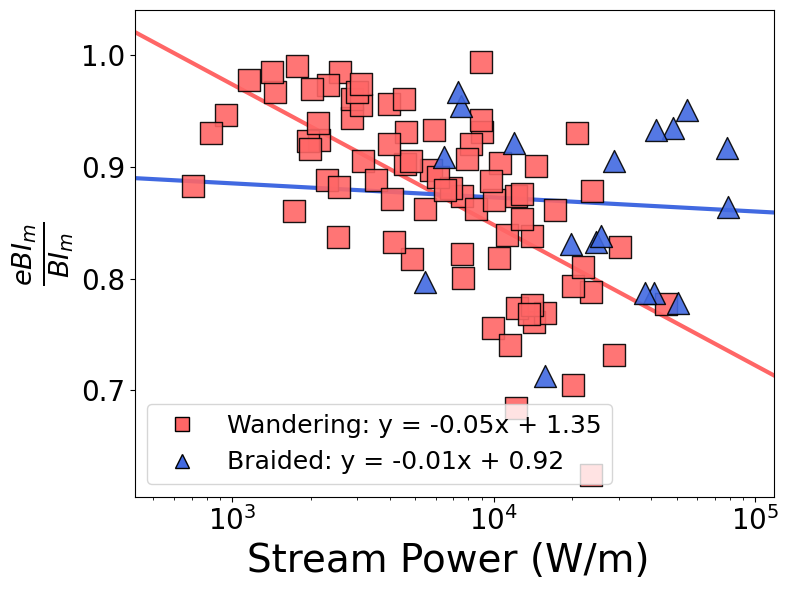

In [28]:

# Dynamically calculate x_range based on data
x_range = (df['Stream Power (W/m) '].min() * 0.6, df['Stream Power (W/m) '].max() * 1.5)  # Add 10% padding

def fit_regression(x_data, y_data, x_range):
    # Filter valid values (positive, non-zero x_data)
    valid_mask = (x_data > 0) & ~x_data.isnull() & ~y_data.isnull()
    x_data = x_data[valid_mask]
    y_data = y_data[valid_mask]
    
    if len(x_data) < 2:  # Ensure enough data points for regression
        print("Not enough valid data points for regression.")
        return None, None, float('nan'), float('nan')
    
    log_x_data = np.log(x_data)
    slope, intercept, r_value, p_value, std_err = stats.linregress(log_x_data, y_data)
    r_squared = r_value**2  # Calculate R^2 value

    line_x = np.linspace(np.log(x_range[0]), np.log(x_range[1]), 300)
    line_y = slope * line_x + intercept
    print(f"Slope: {slope:.4f}, Intercept: {intercept:.4f}, R-squared: {r_squared:.4f}")  # Print results
    
    return np.exp(line_x), line_y, slope, intercept


# Create the figure and axes
fig, ax = plt.subplots(figsize=(8, 6))

# Define markers and colors
markers = {'Wandering': 's', 'B': '^'}  # Combined HSW and LSW symbols
colors = {'Wandering': '#FF6666', 'B': '#4169E1'}

# Combine wandering classifications into one group
df['Group'] = df['Classification'].replace(wandering_types, 'Wandering')

# Variables to store regression line equations for legend
legend_labels = {}
for group in ['Wandering', 'B']:
    subset = df[df['Group'] == group]
    x_data = subset['Stream Power (W/m) ']
    y_data = subset['eBI_BI_ratio_time']
    line_x, line_y, slope, intercept = fit_regression(x_data, y_data, x_range)
    
    # Plot regression line
    ax.plot(line_x, line_y, color=colors[group], lw=3)
    
    # Store regression equation for legend
    legend_labels[group] = f"{slope:.2f}x + {intercept:.2f}"

# Plot data points with error bars
for group in ['Wandering', 'B']:
    subset = df[df['Group'] == group]
    x_data = subset['Stream Power (W/m) ']
    y_data = subset['eBI_BI_ratio_time']
    error_data = subset['ebi_error_annual']
    
    # Scatter plot with error bars
    #ax.errorbar(x_data, y_data, yerr=error_data, fmt='none', ecolor='black', elinewidth=2, capsize=5, zorder=1)
    ax.scatter(x_data, y_data, label=group, marker=markers[group], c=colors[group], edgecolors='black', 
               s=250, alpha=0.9, zorder=2)

# Set log scale for x-axis
ax.set_xscale('log')
#ax.set_ylim(bottom=0, top=8.5)
ax.set_xlim(*x_range)

# Set labels and ticks
ax.set_xlabel(r'Stream Power (W/m) ', fontsize=28)  # Display fraction as LaTeX
ax.set_ylabel(r'$\frac{eBI_{m}}{BI_{m}}$', fontsize=28)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)

# Create a legend with regression equations
legend_elements = [
    Line2D([0], [0], marker=markers['Wandering'], color='w',
           label=f"Wandering: y = {legend_labels['Wandering']}",
           markerfacecolor=colors['Wandering'], markersize=10, markeredgecolor='black'),
    Line2D([0], [0], marker=markers['B'], color='w',
           label=f"Braided: y = {legend_labels['B']}",
           markerfacecolor=colors['B'], markersize=10, markeredgecolor='black')
]

ax.legend(handles=legend_elements, fontsize=18, loc='lower left')

# Tight layout and save figure
plt.tight_layout()
plt.show()

fig.savefig(r"C:\Users\Feifei\Box\BR_remote_sensing\figures\eBI_BI_slope.pdf", 
            format='pdf', dpi=500, bbox_inches='tight', transparent=True)

Slope: -0.0422, Intercept: 1.2105, R-squared: 0.6894
Slope: -0.0463, Intercept: 1.2302, R-squared: 0.5636


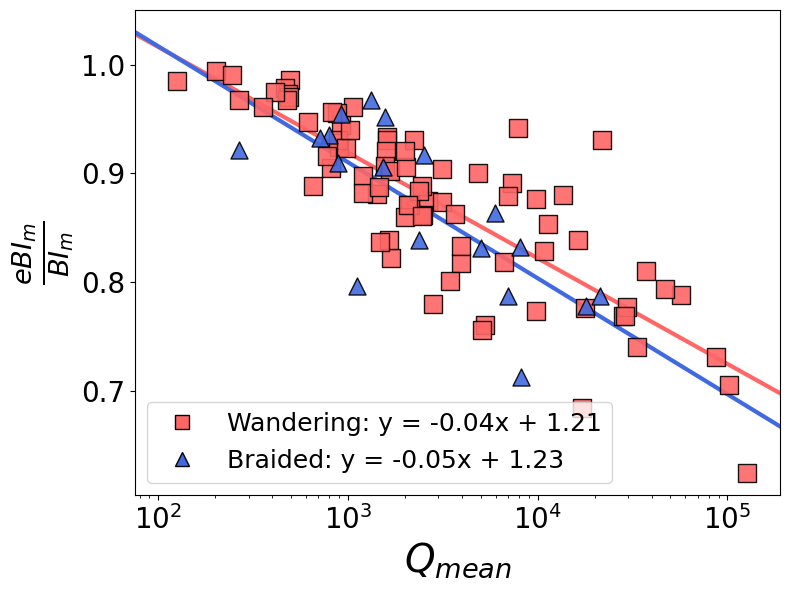

In [21]:

# Dynamically calculate x_range based on data
x_range = (df['Qm'].min() * 0.6, df['Qm'].max() * 1.5)  # Add 10% padding

def fit_regression(x_data, y_data, x_range):
    # Filter valid values (positive, non-zero x_data)
    valid_mask = (x_data > 0) & ~x_data.isnull() & ~y_data.isnull()
    x_data = x_data[valid_mask]
    y_data = y_data[valid_mask]
    
    if len(x_data) < 2:  # Ensure enough data points for regression
        print("Not enough valid data points for regression.")
        return None, None, float('nan'), float('nan')
    
    log_x_data = np.log(x_data)
    slope, intercept, r_value, p_value, std_err = stats.linregress(log_x_data, y_data)
    r_squared = r_value**2  # Calculate R^2 value

    line_x = np.linspace(np.log(x_range[0]), np.log(x_range[1]), 300)
    line_y = slope * line_x + intercept
    print(f"Slope: {slope:.4f}, Intercept: {intercept:.4f}, R-squared: {r_squared:.4f}")  # Print results
    
    return np.exp(line_x), line_y, slope, intercept


# Create the figure and axes
fig, ax = plt.subplots(figsize=(8, 6))

# Define markers and colors
markers = {'Wandering': 's', 'B': '^'}  # Combined HSW and LSW symbols
colors = {'Wandering': '#FF6666', 'B': '#4169E1'}

# Combine wandering classifications into one group
df['Group'] = df['Classification'].replace(wandering_types, 'Wandering')

# Variables to store regression line equations for legend
legend_labels = {}
for group in ['Wandering', 'B']:
    subset = df[df['Group'] == group]
    x_data = subset['Qm']
    y_data = subset['eBI_BI_ratio_time']
    line_x, line_y, slope, intercept = fit_regression(x_data, y_data, x_range)
    
    # Plot regression line
    ax.plot(line_x, line_y, color=colors[group], lw=3)
    
    # Store regression equation for legend
    legend_labels[group] = f"{slope:.2f}x + {intercept:.2f}"

# Plot data points with error bars
for group in ['Wandering', 'B']:
    subset = df[df['Group'] == group]
    x_data = subset['Qm']
    y_data = subset['eBI_BI_ratio_time']
    error_data = subset['ebi_error_annual']
    
    # Scatter plot with error bars
    #ax.errorbar(x_data, y_data, yerr=error_data, fmt='none', ecolor='black', elinewidth=2, capsize=5, zorder=1)
    ax.scatter(x_data, y_data, label=group, marker=markers[group], c=colors[group], edgecolors='black', 
               s=150, alpha=0.9, zorder=2)

# Set log scale for x-axis
ax.set_xscale('log')
#ax.set_ylim(bottom=0, top=8.5)
ax.set_xlim(*x_range)

# Set labels and ticks
ax.set_xlabel(r'${Q_{mean}}$', fontsize=28)
ax.set_ylabel(r'$\frac{eBI_{m}}{BI_{m}}$', fontsize=28)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)

# Create a legend with regression equations
legend_elements = [
    Line2D([0], [0], marker=markers['Wandering'], color='w',
           label=f"Wandering: y = {legend_labels['Wandering']}",
           markerfacecolor=colors['Wandering'], markersize=10, markeredgecolor='black'),
    Line2D([0], [0], marker=markers['B'], color='w',
           label=f"Braided: y = {legend_labels['B']}",
           markerfacecolor=colors['B'], markersize=10, markeredgecolor='black')
]

ax.legend(handles=legend_elements, fontsize=18, loc='lower left')
# Tight layout and save figure
plt.tight_layout()
plt.show()



### Figure 6

Slope: -0.0376, Intercept: 0.5285, R-squared: 0.3013


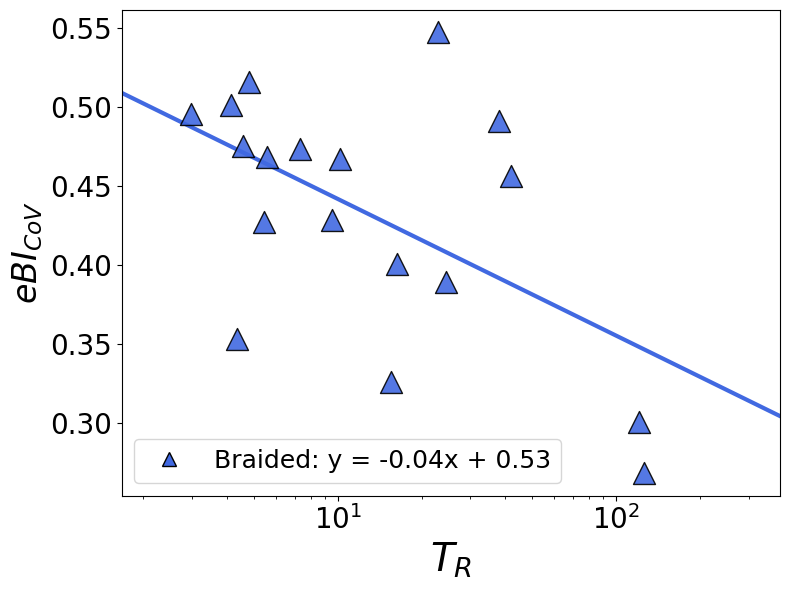

In [22]:
# Dynamically calculate x_range based on data
x_range = (df['T_R'].min() * 0.6, df['T_R'].max() * 1.5)  # Add 10% padding

def fit_regression(x_data, y_data, x_range):
    # Filter valid values (positive, non-zero x_data)
    valid_mask = (x_data > 0) & ~x_data.isnull() & ~y_data.isnull()
    x_data = x_data[valid_mask]
    y_data = y_data[valid_mask]
    
    if len(x_data) < 2:  # Ensure enough data points for regression
        print("Not enough valid data points for regression.")
        return None, None, float('nan'), float('nan')
    
    log_x_data = np.log(x_data)
    slope, intercept, r_value, p_value, std_err = stats.linregress(log_x_data, y_data)
    r_squared = r_value**2  # Calculate R^2 value

    line_x = np.linspace(np.log(x_range[0]), np.log(x_range[1]), 300)
    line_y = slope * line_x + intercept
    print(f"Slope: {slope:.4f}, Intercept: {intercept:.4f}, R-squared: {r_squared:.4f}")  # Print results
    
    return np.exp(line_x), line_y, slope, intercept

# Create the figure and axes
fig, ax = plt.subplots(figsize=(8, 6))

# Define markers and colors
markers = {'B': '^'}  # Keep only braided markers
colors = {'B': '#4169E1'}  # Keep only braided color

# Variables to store regression line equations for legend
legend_labels = {}
for group in ['B']:  # Keep only braided group
    subset = df[df['Group'] == group]
    x_data = subset['T_R']
    y_data = subset['cov_ebi_annual']
    line_x, line_y, slope, intercept = fit_regression(x_data, y_data, x_range)
    
    # Plot regression line
    ax.plot(line_x, line_y, color=colors[group], lw=3)
    
    # Store regression equation for legend
    legend_labels[group] = f"{slope:.2f}x + {intercept:.2f}"

# Plot data points with error bars
for group in ['B']:  # Keep only braided group
    subset = df[df['Group'] == group]
    x_data = subset['T_R']
    y_data = subset['cov_ebi_annual']
    error_data = subset['ebi_error_annual']
    
    # Scatter plot with error bars
    ax.scatter(x_data, y_data, label=group, marker=markers[group], c=colors[group], edgecolors='black', 
               s=250, alpha=0.9, zorder=2)

# Set log scale for x-axis
ax.set_xscale('log')
ax.set_xlim(*x_range)

# Set labels and ticks
ax.set_xlabel(r'$T_R$', fontsize=28)  # "R" as a subscript
ax.set_ylabel(r'${eBI_{CoV}}$', fontsize=24)  # Updated y-axis label
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)

# Create a legend with regression equations
legend_elements = [
    Line2D([0], [0], marker=markers['B'], color='w',
           label=f"Braided: y = {legend_labels['B']}",
           markerfacecolor=colors['B'], markersize=10, markeredgecolor='black')
]

ax.legend(handles=legend_elements, fontsize=18, loc='lower left')

# Tight layout and save figure
plt.tight_layout()
plt.show()

fig.savefig(r"C:\Users\Feifei\Box\BR_remote_sensing\figures\eBI_cov_TR_B.pdf", 
            format='pdf', dpi=500, bbox_inches='tight', transparent=True)

Slope: -0.0045, Intercept: 0.4815, R-squared: 0.0024


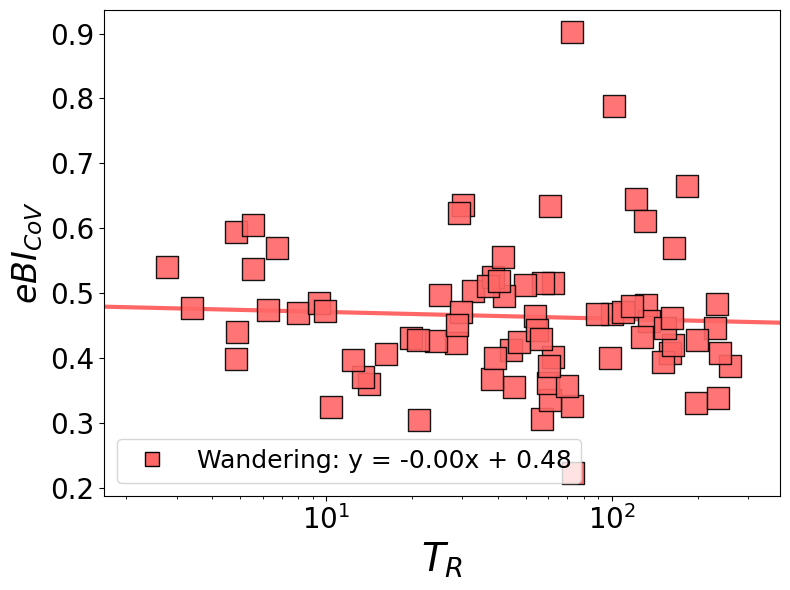

In [23]:
# Dynamically calculate x_range based on data
x_range = (df['T_R'].min() * 0.6, df['T_R'].max() * 1.5)  # Add padding

def fit_regression(x_data, y_data, x_range):
    # Filter valid values (positive, non-zero x_data)
    valid_mask = (x_data > 0) & ~x_data.isnull() & ~y_data.isnull()
    x_data = x_data[valid_mask]
    y_data = y_data[valid_mask]
    
    if len(x_data) < 2:  # Ensure enough data points for regression
        print("Not enough valid data points for regression.")
        return None, None, float('nan'), float('nan')
    
    log_x_data = np.log(x_data)
    slope, intercept, r_value, p_value, std_err = stats.linregress(log_x_data, y_data)
    r_squared = r_value**2  # Calculate R^2 value

    line_x = np.linspace(np.log(x_range[0]), np.log(x_range[1]), 300)
    line_y = slope * line_x + intercept
    print(f"Slope: {slope:.4f}, Intercept: {intercept:.4f}, R-squared: {r_squared:.4f}")  # Print results
    
    return np.exp(line_x), line_y, slope, intercept

# Create the figure and axes
fig, ax = plt.subplots(figsize=(8, 6))

# Define markers and colors for wandering rivers
markers = {'Wandering': 's'}  # Single marker for HSW and LSW
colors = {'Wandering': '#FF6666'}  # Single color for HSW and LSW

# Combine HSW and LSW as "Wandering"
df['Group'] = df['Classification'].apply(lambda x: 'Wandering' if x in ['HSW', 'LSW'] else x)

# Variables to store regression line equations for legend
legend_labels = {}
for group in ['Wandering']:  # Keep only wandering group
    subset = df[df['Group'] == group]
    x_data = subset['T_R']
    y_data = subset['cov_ebi_annual']
    line_x, line_y, slope, intercept = fit_regression(x_data, y_data, x_range)
    
    # Plot regression line
    ax.plot(line_x, line_y, color=colors[group], lw=3)
    
    # Store regression equation for legend
    legend_labels[group] = f"{slope:.2f}x + {intercept:.2f}"

# Plot data points with error bars
for group in ['Wandering']:  # Keep only wandering group
    subset = df[df['Group'] == group]
    x_data = subset['T_R']
    y_data = subset['cov_ebi_annual']
    error_data = subset['ebi_error_annual']
    
    # Scatter plot with error bars
    ax.scatter(x_data, y_data, label=group, marker=markers[group], c=colors[group], edgecolors='black', 
               s=250, alpha=0.9, zorder=2)

# Set log scale for x-axis
ax.set_xscale('log')
ax.set_xlim(*x_range)

# Set labels and ticks
ax.set_xlabel(r'$T_R$', fontsize=28)  # "R" as a subscript
ax.set_ylabel(r'${eBI_{CoV}}$', fontsize=24)  # Updated y-axis label
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)

# Create a legend with regression equations
legend_elements = [
    Line2D([0], [0], marker=markers['Wandering'], color='w',
           label=f"Wandering: y = {legend_labels['Wandering']}",
           markerfacecolor=colors['Wandering'], markersize=10, markeredgecolor='black')
]

ax.legend(handles=legend_elements, fontsize=18, loc='lower left')

# Tight layout and save figure
plt.tight_layout()
plt.show()

fig.savefig(r"C:\Users\Feifei\Box\BR_remote_sensing\figures\eBI_cov_TR_W.pdf", 
            format='pdf', dpi=500, bbox_inches='tight', transparent=True)


Slope: -0.7290, Intercept: 2.5815, R-squared: 0.2158


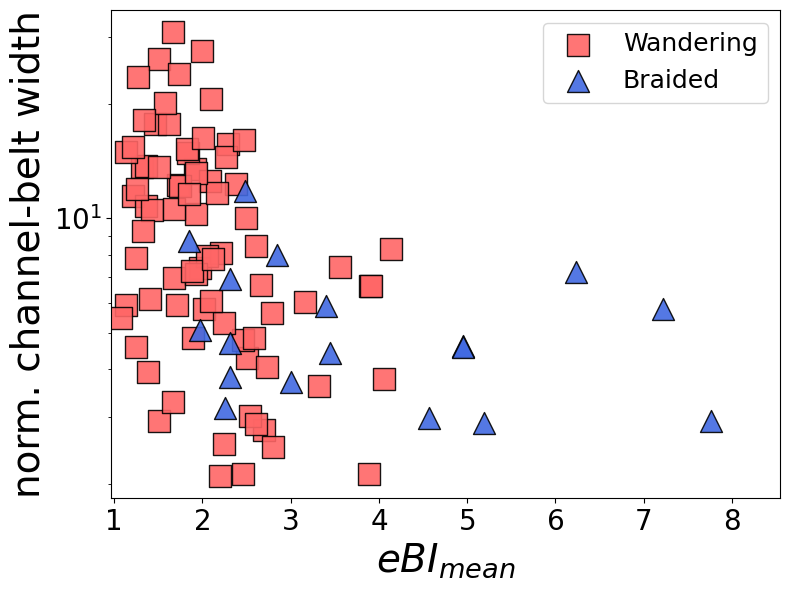

In [31]:
# Dynamically calculate x_range based on combined data
x_range = (combined_x_data.min() * 0.9, combined_x_data.max() * 1.1)  # Add 10% padding

# Updated fit_regression function with log-log adjustments
def fit_regression(x_data, y_data, x_range):
    # Filter valid values (positive, non-zero x_data and y_data)
    valid_mask = (x_data > 0) & (y_data > 0) & ~x_data.isnull() & ~y_data.isnull()
    x_data = x_data[valid_mask]
    y_data = y_data[valid_mask]
    
    if len(x_data) < 2:  # Ensure enough data points for regression
        print("Not enough valid data points for regression.")
        return None, None, float('nan'), float('nan')
    
    log_x_data = np.log(x_data)
    log_y_data = np.log(y_data)
    
    # Perform regression in log-log space
    slope, intercept, r_value, p_value, std_err = stats.linregress(log_x_data, log_y_data)
    r_squared = r_value**2  # Calculate R^2 value

    # Generate line_x in the log-space and back-transform line_y to original scale
    line_x = np.linspace(np.log(x_range[0]), np.log(x_range[1]), 300)
    line_y = slope * line_x + intercept  # Line in log-log space
    print(f"Slope: {slope:.4f}, Intercept: {intercept:.4f}, R-squared: {r_squared:.4f}")  # Print results
    
    return np.exp(line_x), np.exp(line_y), slope, intercept  # Transform back to original scale

# Combine data for all groups
combined_x_data = df['Mean_eBI_annual']
combined_y_data = df['CB/Aw']

# Fit a single regression line for all data
line_x, line_y, slope, intercept = fit_regression(combined_x_data, combined_y_data, x_range)

# Create the figure and axes
fig, ax = plt.subplots(figsize=(8, 6))

# Define markers and colors
markers = {'Wandering': 's', 'B': '^'}
colors = {'Wandering': '#FF6666', 'B': '#4169E1'}

# Plot the combined regression line
# if line_x is not None and line_y is not None:
#     ax.plot(line_x, line_y, color='black', lw=3, label=f"Combined: y = {slope:.2f}x + {intercept:.2f}")

# Plot data points for each group
for group in ['Wandering', 'B']:
    subset = df[df['Group'] == group]
    x_data = subset['Mean_eBI_annual']
    y_data = subset['CB/Aw']
    label = 'Wandering' if group == 'Wandering' else 'Braided'  # Correct label for the groups
    ax.scatter(x_data, y_data, label=label, marker=markers[group], c=colors[group], edgecolors='black', 
               s=250, alpha=0.9, zorder=2)

# Set log scale for y-axis
ax.set_yscale('log')
ax.set_xlim(*x_range)

# Set labels and ticks
ax.set_xlabel(r'${eBI_{mean}}$', fontsize=28)
ax.set_ylabel('norm. channel-belt width', fontsize=28)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)

# Create a legend
ax.legend(fontsize=18, loc='upper right')

# Tight layout and show figure
plt.tight_layout()
plt.show()

fig.savefig(r"C:\Users\Feifei\Box\BR_remote_sensing\figures\eBI_cb.pdf", 
            format='pdf', dpi=500, bbox_inches='tight', transparent=True)



Slope: -0.9364, Intercept: -0.6484, R-squared: 0.6222


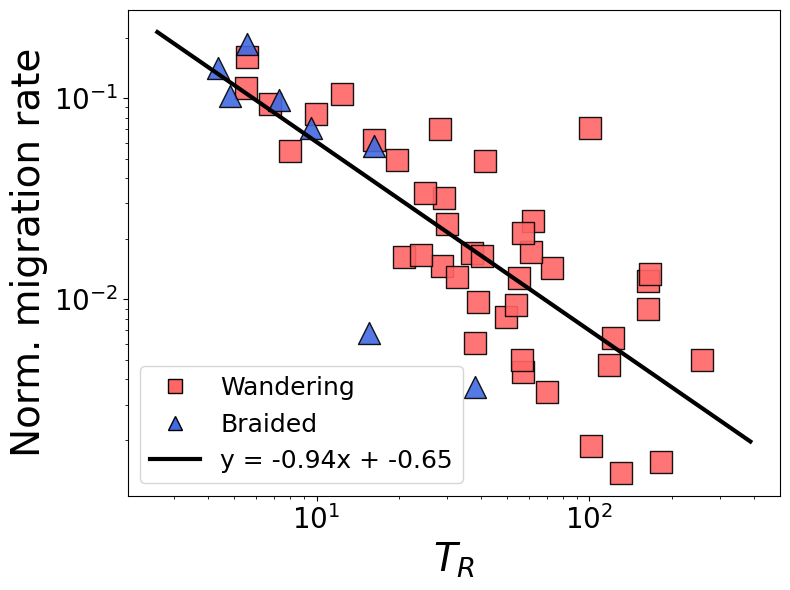

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from matplotlib.lines import Line2D

# File path for the CSV file
migration_rate_file = r"C:\Users\Feifei\Box\BR_remote_sensing\merged_PIV_eBI_TR.csv"

# Load the data
df = pd.read_csv(migration_rate_file)

# Remove points with zero migration rates
df = df[df['Mean migration rate [m/yr]'] > 0]

# Calculate the y-axis values: "Mean migration rate [m/yr]" divided by "Average wetted width [m]"
df['y_values'] = df['Mean migration rate [m/yr]'] / df['Average wetted width [m]']

df['x_values'] = df['T_R']

# Combine wandering classifications into one group
wandering_types = ['HSW', 'LSW']
df['Group'] = df['Classification'].replace(wandering_types, 'Wandering')

# Dynamically calculate x_range based on data
x_range = (df['x_values'].min() * 0.6, df['x_values'].max() * 1.5)  # Add padding

# Fit regression function
def fit_regression(x_data, y_data, x_range):
    # Filter valid values (positive, non-zero x_data)
    valid_mask = (x_data > 0) & ~x_data.isnull() & ~y_data.isnull()
    x_data = x_data[valid_mask]
    y_data = y_data[valid_mask]
    
    if len(x_data) < 2:  # Ensure enough data points for regression
        print("Not enough valid data points for regression.")
        return None, None, float('nan'), float('nan')
    
    log_x_data = np.log(x_data)
    log_y_data = np.log(y_data)
    
    # Perform regression in log-log space
    slope, intercept, r_value, p_value, std_err = stats.linregress(log_x_data, log_y_data)
    r_squared = r_value**2  # Calculate R^2 value

    line_x = np.linspace(np.log(x_range[0]), np.log(x_range[1]), 300)
    line_y = slope * line_x + intercept
    print(f"Slope: {slope:.4f}, Intercept: {intercept:.4f}, R-squared: {r_squared:.4f}")  # Print results
    
    return np.exp(line_x), np.exp(line_y), slope, intercept

# Fit a single regression line combining all data
combined_x_data = df['x_values']
combined_y_data = df['y_values']
line_x, line_y, slope, intercept = fit_regression(combined_x_data, combined_y_data, x_range)

# Create the figure and axes
fig, ax = plt.subplots(figsize=(8, 6))

# Define markers and colors
markers = {'Wandering': 's', 'B': '^'}
colors = {'Wandering': '#FF6666', 'B': '#4169E1'}

# Plot the regression line
if line_x is not None and line_y is not None:
    ax.plot(line_x, line_y, color='black', lw=3, label=f"Combined: y = {slope:.2f}x + {intercept:.2f}")

# Plot data points
for group in ['Wandering', 'B']:
    subset = df[df['Group'] == group]
    x_data = subset['x_values']
    y_data = subset['y_values']
    ax.scatter(
        x_data, y_data,
        label='Wandering' if group == 'Wandering' else 'Braided',
        marker=markers[group], c=colors[group], edgecolors='black', s=250, alpha=0.9
    )

# Set log scales for both axes
ax.set_xscale('log')
ax.set_yscale('log')

# Set labels and ticks
ax.set_xlabel(r'$T_R$', fontsize=28)
ax.set_ylabel('Norm. migration rate', fontsize=28)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)

# Create a legend
legend_elements = [
    Line2D([0], [0], marker=markers['Wandering'], color='w',
           label="Wandering", markerfacecolor=colors['Wandering'], markersize=10, markeredgecolor='black'),
    Line2D([0], [0], marker=markers['B'], color='w',
           label="Braided", markerfacecolor=colors['B'], markersize=10, markeredgecolor='black'),
    Line2D([0], [0], color='black', lw=3, label=f"y = {slope:.2f}x + {intercept:.2f}")
]
ax.legend(handles=legend_elements, fontsize=18, loc='lower left')

# Tight layout and show plot
plt.tight_layout()
plt.show()

fig.savefig(r"C:\Users\Feifei\Box\BR_remote_sensing\figures\Tr_vs_Migration_rate.pdf", 
            format='pdf', dpi=500, bbox_inches='tight', transparent=True)


### Supporting Plots

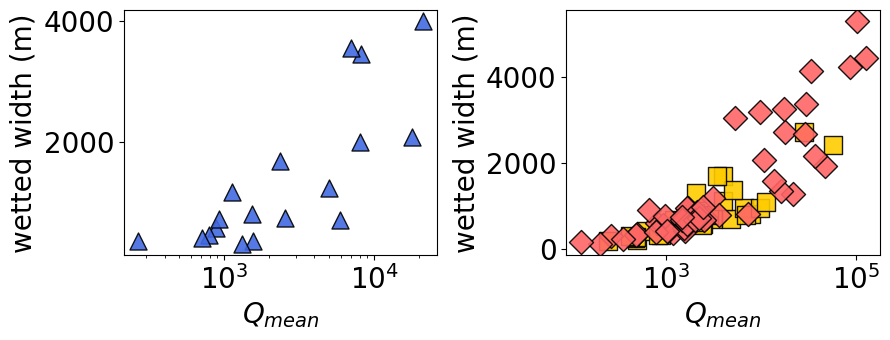

In [ ]:

# Create the figure and axes for subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 3.5))

# Define markers and colors for each planform type
markers = {'HSW': 's', 'LSW': 'D', 'B': '^'} 
colors = {'HSW': '#FFCC00', 'LSW': '#FF6666', 'B': '#4169E1'}

# Planform type descriptions
planform_type = {'HSW': 'High-sinuosity wandering', 'LSW': 'Low-sinuosity wandering', 'B': 'Braided'}

# Plot each classification on the appropriate subplot
for cls in ['B']:
    subset = df[df['Classification'] == cls]
    x_data = subset['Qm']
    y_data = subset['wetted_area_avg_subannual']
    ax1.scatter(x_data, y_data, label=cls, marker=markers[cls], c=colors[cls], edgecolors='black', s=150, alpha=0.9)

for cls in ['HSW', 'LSW']:
    subset = df[df['Classification'] == cls]
    x_data = subset['Qm']
    y_data = subset['wetted_area_avg_subannual']
    ax2.scatter(x_data, y_data, label=cls, marker=markers[cls], c=colors[cls], edgecolors='black', s=150, alpha=0.9)
# Create custom legends for scatter points
legend_elements = [Line2D([0], [0], marker='s', color='w', label=planform_type[cls],
                          markerfacecolor=colors[cls], markersize=10, markeredgecolor='black') for cls in markers]

# Set log scale for x-axis and labels for axes for both subplots
for ax in (ax1, ax2):
    ax.set_xscale('log')

    ax.set_xlabel(r'${Q_{mean}}$', fontsize=20)

    #ax.set_xlabel('mean discharge (m³/s)', fontsize=22)
    ax.set_ylabel(r'wetted width (m)', fontsize=20)
    ax.tick_params(axis='x', labelsize=20)  # Set x-axis tick label size
    ax.tick_params(axis='y', labelsize=20)  # Set y-axis tick label size

plt.tight_layout()
plt.show()

fig.savefig(r"C:\Users\Feifei\Box\BR_remote_sensing\figures\Q_wettedwidth_mean.pdf", format='pdf',dpi=500, bbox_inches='tight',transparent=True)

